In [19]:
from os import listdir
from os.path import isfile, join

import re
from itertools import combinations
from itertools import chain

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson


import folium.folium

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins

%matplotlib inline

pd.set_option('display.max_rows', 1000)

In [10]:
CLEAN_PATH = '../data/clean'

In [12]:
all_raw_geofiles = [f for f in listdir(CLEAN_PATH) if isfile(join(CLEAN_PATH, f))]
all_raw_geofiles

['cadastralparcel.geojson',
 'otherconstruction.geojson',
 'buildingpart.geojson',
 'cadastralzoning.geojson',
 'building.geojson',
 '28900.geojson']

In [17]:
names_dict = {
    
    'cad_pa_gdf': 'CAD_PA',
    'o_build_gdf': 'O_CONS',
    'p_build_gdf': 'P_BU',
    'build_gdf': 'BU',
    'cad_zo_gdf': 'CAD_ZO'
}

cad_pa_gdf = gpd.read_file(f"{CLEAN_PATH}/cadastralparcel.geojson")
cad_pa_gdf.name = "CAD_PA"

"""
o_build_gdf = gpd.read_file(f"{CLEAN_PATH}/otherconstruction.geojson")
o_build_gdf.name = "CAD_PA"

buildingpart = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[2]}")
buildingpart.name = "CAD_PA"



building = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[4]}")
building.name = "CAD_PA"
"""

'\no_build_gdf = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[1]}")\no_build_gdf.name = "CAD_PA"\n\nbuildingpart = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[2]}")\nbuildingpart.name = "CAD_PA"\n\ncadastralzoning = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[3]}")\ncadastralzoning.name = "CAD_PA"\n\nbuilding = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[4]}")\nbuilding.name = "CAD_PA"\n'

In [28]:
# yearofConstruction doesn't indicate that in this case but when the parcel has been included in database.
# beginLifespanVersion: Fecha desde cuándo se ha dado de alta en la base de datos catastral. 

# cp:label: Es el número de parcela y corresponde al número que vemos representado en la cartografía.
# Para parcelas urbanas son 2 dígitos y para parcelas rústicas pueden ser hasta de 5 dígitos. 

# cp:referencePoint: Estructura GML de punto con las coordenadas del centroide de la parcela. Es un punto
# interior al recinto y es donde se justifica la posición de “cp:label” en los servicios de visualización


# TO DO: pos to POINT(())

cad_pa_gdf.drop(['label', 'yearOfConstruction'], axis = 1, inplace = True)
cad_pa_gdf.head()

,ID,area_m2p,pos,geometry
0,000200500VK56E,1268,451607.03 4467199.27,"MULTIPOLYGON (((451599.360 4467174.940, 451584..."
1,000205600VK56E,297,451592.44 4467170.83,"MULTIPOLYGON (((451593.000 4467163.250, 451579..."
2,000205700VK56E,155,451587.93 4467161.77,"MULTIPOLYGON (((451590.040 4467156.910, 451576..."
3,000205800VK56E,174,451584.62 4467155.04,"MULTIPOLYGON (((451586.650 4467149.650, 451573..."
4,000205900VK56E,172,451581.09 4467147.85,"MULTIPOLYGON (((451583.260 4467142.410, 451569..."


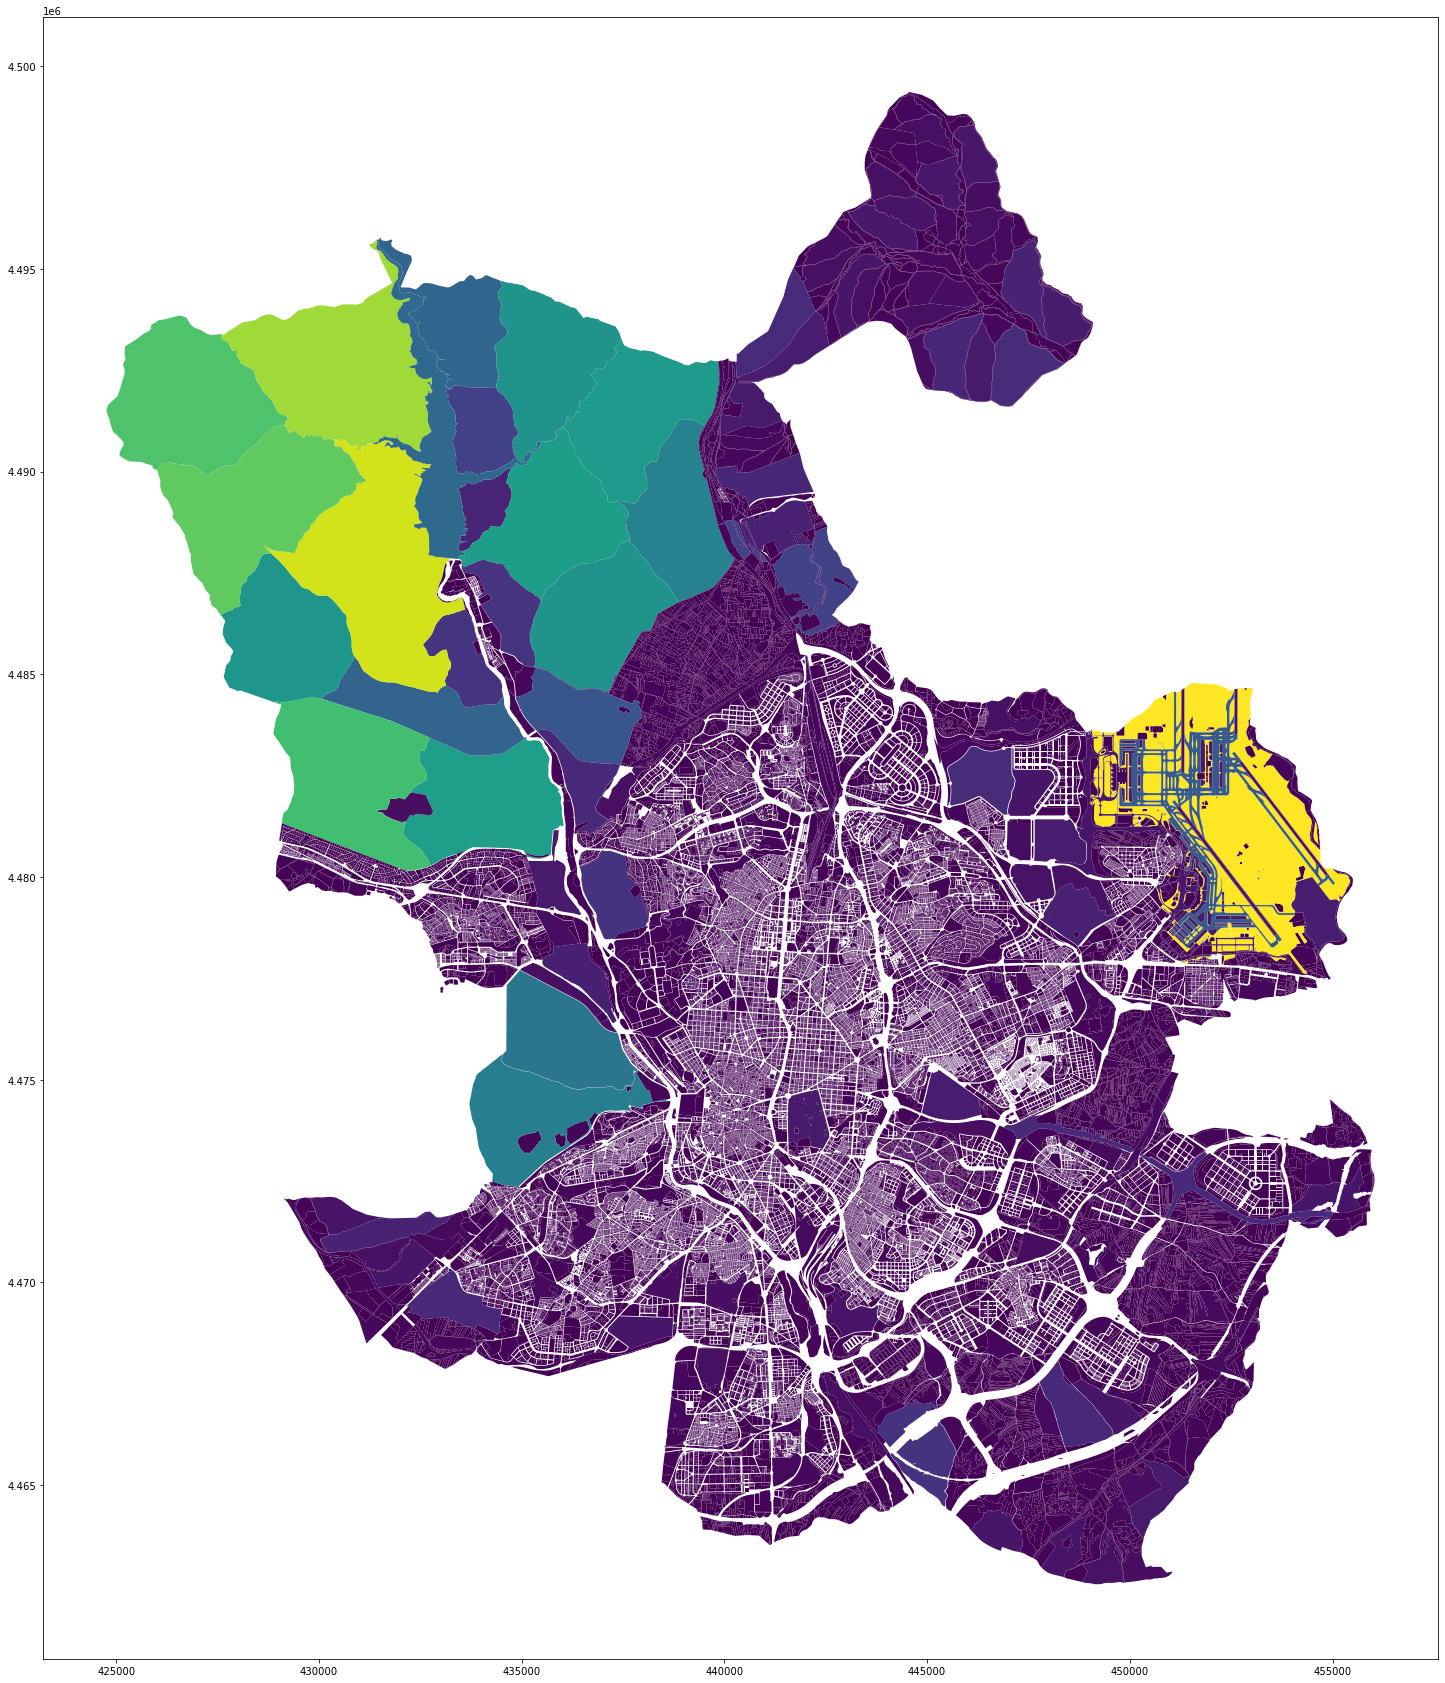

In [30]:
col_to_draw = 'area_m2p' #
cad_pa_gdf[['geometry', col_to_draw]].plot(figsize = (25,35), column = col_to_draw, legend=False)
plt.show()

In [31]:
cad_zo_gdf = gpd.read_file(f"{CLEAN_PATH}/{all_raw_geofiles[3]}")
cad_zo_gdf.name = names_dict['cad_zo_gdf']

In [32]:
cad_zo_gdf.head()

,ID,estimatedAccuracy,label,pos,yearOfConstruction,geometry
0,28900A000,1.0,000,440302.42 4492704.6,2019,"MULTIPOLYGON (((440301.968 4492704.637, 440302..."
1,28900A001,1.0,001,444909.27 4497953.5,2019,"MULTIPOLYGON (((444555.092 4499363.444, 444568..."
2,28900A002,1.0,002,446474.92 4496527.94,2013,"MULTIPOLYGON (((445948.540 4496495.370, 445945..."
3,28900A003,1.0,003,447749.11 4494280.98,2014,"MULTIPOLYGON (((449091.096 4493635.359, 449089..."
4,28900A004,1.0,004,447065.76 4493887.71,2013,"MULTIPOLYGON (((445797.560 4495048.620, 445790..."


In [ ]:
col_to_draw = 'area_m2p' #
cad_pa_gdf[['geometry', col_to_draw]].plot(figsize = (25,35), column = col_to_draw, legend=False)
plt.show()